# Rebust Url Malware Detection
some explanning

In [2]:
import numpy as np
import seaborn as sns 
import pandas as pd 
import matplotlib.pyplot as plt
from Helpers.preprocess.main import *
from Helpers.experiments import experiments
from Helpers.models.simple_ml import *
from Helpers.preprocess.content_based_features import get_content_based_features
from Helpers.preprocess.host_based_features import get_host_based_features
from Helpers.preprocess.lexical_url_features import get_lexical_url_features


In [3]:
df = pd.read_csv("Data/malicious_phish.csv")
df

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


<AxesSubplot:xlabel='type', ylabel='count'>

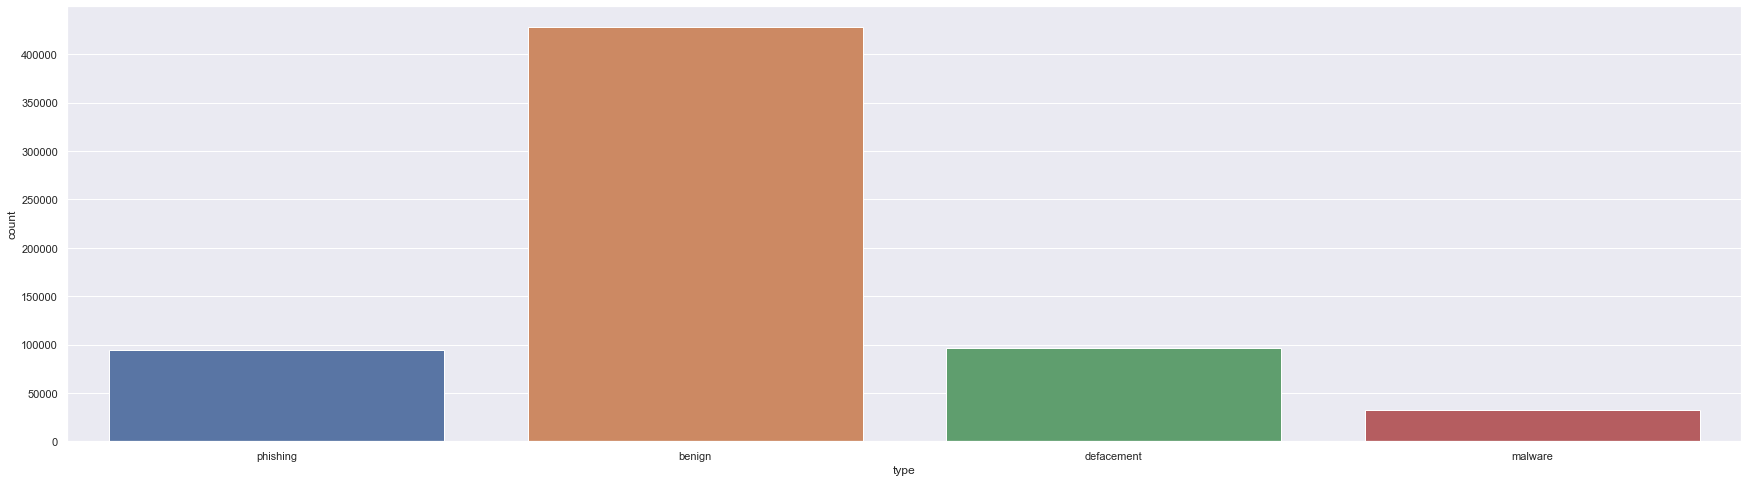

In [4]:
sns.set(rc={'figure.figsize':(30,8)})
sns.countplot(data=df, x='type')

<BarContainer object of 2 artists>

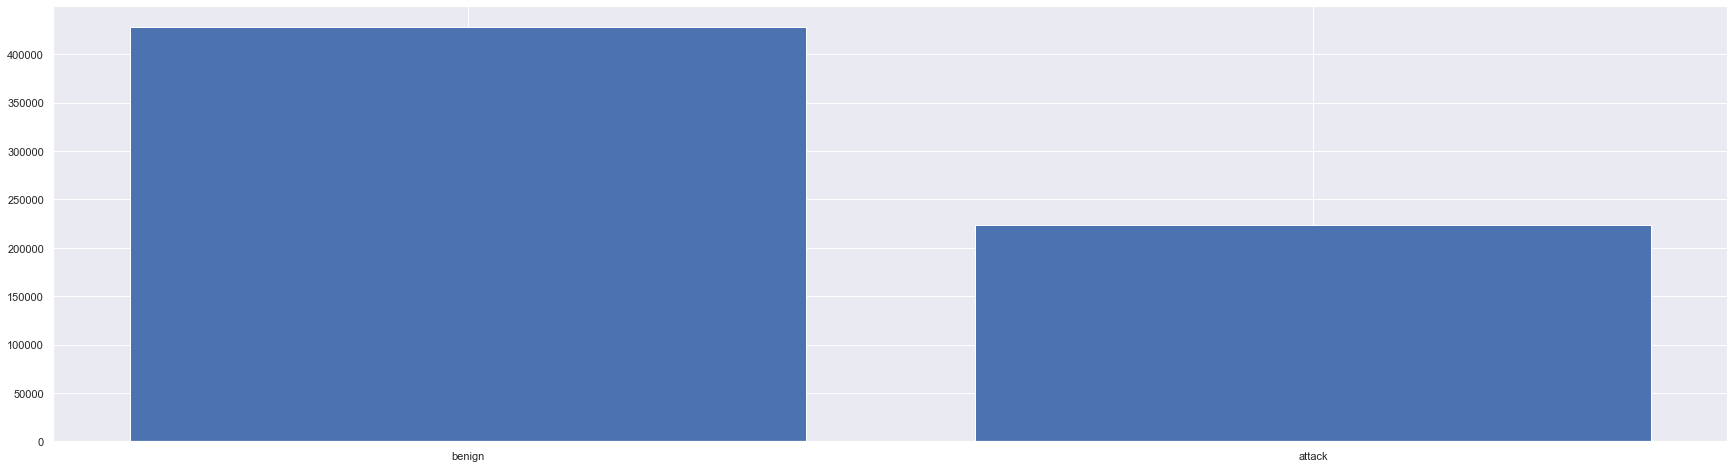

In [5]:
plt.bar(["benign","attack"],[(df['type']=='benign').sum(),(df['type']!='benign').sum()])

## Preproccess

### Lexical Features: 
These refer to statistical features extracted from the literal URL string. For example, length of the URL string, number of digits, number of parameters in its query part, if the URL is encoded, etc.
see https://towardsdatascience.com/extracting-feature-vectors-from-url-strings-for-malicious-url-detection-cbafc24737a

### Content-Based Features
These are obtained from the downloaded HTML code of the webpage. These features capture the structure of the webpage and the content embedded in it. These will include information on script tags, embedded objects, executables, hidden elements, etc.

### Host-Based Features
these are characteristics of the host-name properties of the URL. These provide information about the host of the webpage, for example, country of registration, domain name properties, open ports, named servers, connection speed, time to live from registration, etc.

In [6]:
df = preprocess(cache=True,features_extractors=(get_lexical_url_features,))

In [43]:
# list(df.select_dtypes('O').columns)
# df[df.isna().any(axis=1)].head()
#df = df.dropna(axis='index')

['url', 'url_schema', 'tld']

In [7]:
df

,url,type,url_length,url_path_length,url_host_length,url_host_is_ip,url_has_port_in_string,number_of_digits,number_of_parameters,number_of_fragments,...,á>V>4z¢¶Mù2<¯LOâ¿31È,"äÕ3ñºT- TÖGÑîÊ­ñòò}¼ae° ôÈ>´ôÌ~ÀÁÙD¡êÅszõdÕÄzæ±¨a»¿{Áî¤ÇyÏ!ÙÌ¯H¡ÛìÂ<ëK ³Ù'õ+¬""å+$¤Gh±B",è kvüDâQÎé4¼Ò©,é¾¾T `(+}^«´i\'F4æ }CjÑ,"ëËl×uÏB'JI¨GÙn""Ç( 0",ìUÛ ïwÐºÐãìÌÔÍæÓJ>Òª©dÆtY¹,ïC¿YÂO®,"ñûÉï 9""-b^EÐ2Þe´Ký+M÷ÝÝÚíÏS&ü®\RïÏñ«UýØE½S{ æg¾P^zU= ß"" ­>8º>ér·íú>!;W *ÖOQ v3lõvnêCÑÝÈÜ~ È ·Ud×Ë Þ°<¶Íw\ô""t¤}â",öÂç¼Òé¯¿ÊZ­°Vr³ÑÏ,"úÑ¦~@üþ^t²'ëÆ6T ¯U¶F""-ê}6oã­8aØÜ00"
0,http://br-icloud.com.br,3,23.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,http://mp3raid.com/music/krizz_kaliko.html,0,42.0,24.0,11.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,http://bopsecrets.org/rexroth/cr/1.htm,0,38.0,17.0,14.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,1,88.0,10.0,21.0,0.0,0.0,7.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,http://adventure-nicaragua.net/index.php?optio...,1,235.0,10.0,23.0,0.0,0.0,22.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,http://xbox360.ign.com/objects/850/850402.html,3,46.0,24.0,15.0,0.0,0.0,12.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
651187,http://games.teamxbox.com/xbox-360/1860/Dead-S...,3,51.0,26.0,18.0,0.0,0.0,7.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
651188,http://www.gamespot.com/xbox360/action/deadspace/,3,49.0,26.0,16.0,0.0,0.0,3.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
651189,http://en.wikipedia.org/wiki/Dead_Space_(video...,3,52.0,29.0,16.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## Models

In [8]:
X_train, X_test, y_train, y_test = scale_data(df)

In [7]:
X_train.shape

(520952, 697)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)
weights = pd.Series(y_train).value_counts().values / y_train.size
all_weights = np.zeros(y_train.size)
for label in np.unique(y_train):
    all_weights[y_train == label] = weights[label]
xgb = XGBClassifier(n_estimators=5000, learning_rate=0.05, gamma=0, subsample=0.7,
                         objective="multi:softprob",
                         num_class=len(np.unique(y_train)),
                         eval_metric="mlogloss", random_state=93, use_label_encoder=False)
xgb = xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],
                        early_stopping_rounds=10,
                        sample_weight=all_weights)

[0]	validation_0-mlogloss:1.31933	validation_1-mlogloss:1.31936
[1]	validation_0-mlogloss:1.25951	validation_1-mlogloss:1.25981
[2]	validation_0-mlogloss:1.20578	validation_1-mlogloss:1.20644
[3]	validation_0-mlogloss:1.15779	validation_1-mlogloss:1.15851
[4]	validation_0-mlogloss:1.11422	validation_1-mlogloss:1.11517
[5]	validation_0-mlogloss:1.07458	validation_1-mlogloss:1.07556
[6]	validation_0-mlogloss:1.03848	validation_1-mlogloss:1.03960
[7]	validation_0-mlogloss:1.00545	validation_1-mlogloss:1.00675
[8]	validation_0-mlogloss:0.97451	validation_1-mlogloss:0.97602
[9]	validation_0-mlogloss:0.94616	validation_1-mlogloss:0.94789
[10]	validation_0-mlogloss:0.92019	validation_1-mlogloss:0.92209
[11]	validation_0-mlogloss:0.89609	validation_1-mlogloss:0.89812
[12]	validation_0-mlogloss:0.87380	validation_1-mlogloss:0.87593
[13]	validation_0-mlogloss:0.85306	validation_1-mlogloss:0.85539
[14]	validation_0-mlogloss:0.83391	validation_1-mlogloss:0.83638
[15]	validation_0-mlogloss:0.81619	

[126]	validation_0-mlogloss:0.55271	validation_1-mlogloss:0.56308
[127]	validation_0-mlogloss:0.55195	validation_1-mlogloss:0.56234
[128]	validation_0-mlogloss:0.55100	validation_1-mlogloss:0.56134
[129]	validation_0-mlogloss:0.55032	validation_1-mlogloss:0.56067
[130]	validation_0-mlogloss:0.54970	validation_1-mlogloss:0.56006
[131]	validation_0-mlogloss:0.54862	validation_1-mlogloss:0.55901
[132]	validation_0-mlogloss:0.54795	validation_1-mlogloss:0.55842
[133]	validation_0-mlogloss:0.54732	validation_1-mlogloss:0.55779
[134]	validation_0-mlogloss:0.54676	validation_1-mlogloss:0.55724
[135]	validation_0-mlogloss:0.54603	validation_1-mlogloss:0.55651
[136]	validation_0-mlogloss:0.54536	validation_1-mlogloss:0.55586
[137]	validation_0-mlogloss:0.54485	validation_1-mlogloss:0.55534
[138]	validation_0-mlogloss:0.54410	validation_1-mlogloss:0.55460
[139]	validation_0-mlogloss:0.54355	validation_1-mlogloss:0.55407
[140]	validation_0-mlogloss:0.54300	validation_1-mlogloss:0.55352
[141]	vali

[251]	validation_0-mlogloss:0.50147	validation_1-mlogloss:0.51280
[252]	validation_0-mlogloss:0.50124	validation_1-mlogloss:0.51258
[253]	validation_0-mlogloss:0.50112	validation_1-mlogloss:0.51246
[254]	validation_0-mlogloss:0.50093	validation_1-mlogloss:0.51227
[255]	validation_0-mlogloss:0.50070	validation_1-mlogloss:0.51205
[256]	validation_0-mlogloss:0.50047	validation_1-mlogloss:0.51182
[257]	validation_0-mlogloss:0.50036	validation_1-mlogloss:0.51172
[258]	validation_0-mlogloss:0.50019	validation_1-mlogloss:0.51155
[259]	validation_0-mlogloss:0.49995	validation_1-mlogloss:0.51134
[260]	validation_0-mlogloss:0.49979	validation_1-mlogloss:0.51118
[261]	validation_0-mlogloss:0.49959	validation_1-mlogloss:0.51100
[262]	validation_0-mlogloss:0.49948	validation_1-mlogloss:0.51090
[263]	validation_0-mlogloss:0.49919	validation_1-mlogloss:0.51064
[264]	validation_0-mlogloss:0.49895	validation_1-mlogloss:0.51042
[265]	validation_0-mlogloss:0.49858	validation_1-mlogloss:0.51005
[266]	vali

[376]	validation_0-mlogloss:0.47930	validation_1-mlogloss:0.49160
[377]	validation_0-mlogloss:0.47922	validation_1-mlogloss:0.49153
[378]	validation_0-mlogloss:0.47911	validation_1-mlogloss:0.49142
[379]	validation_0-mlogloss:0.47895	validation_1-mlogloss:0.49127
[380]	validation_0-mlogloss:0.47886	validation_1-mlogloss:0.49118
[381]	validation_0-mlogloss:0.47877	validation_1-mlogloss:0.49109
[382]	validation_0-mlogloss:0.47864	validation_1-mlogloss:0.49096
[383]	validation_0-mlogloss:0.47858	validation_1-mlogloss:0.49090
[384]	validation_0-mlogloss:0.47849	validation_1-mlogloss:0.49081
[385]	validation_0-mlogloss:0.47830	validation_1-mlogloss:0.49063
[386]	validation_0-mlogloss:0.47821	validation_1-mlogloss:0.49054
[387]	validation_0-mlogloss:0.47805	validation_1-mlogloss:0.49038
[388]	validation_0-mlogloss:0.47781	validation_1-mlogloss:0.49015
[389]	validation_0-mlogloss:0.47772	validation_1-mlogloss:0.49007
[390]	validation_0-mlogloss:0.47763	validation_1-mlogloss:0.48999
[391]	vali

[501]	validation_0-mlogloss:0.46346	validation_1-mlogloss:0.47664
[502]	validation_0-mlogloss:0.46335	validation_1-mlogloss:0.47655
[503]	validation_0-mlogloss:0.46321	validation_1-mlogloss:0.47641
[504]	validation_0-mlogloss:0.46313	validation_1-mlogloss:0.47633
[505]	validation_0-mlogloss:0.46292	validation_1-mlogloss:0.47614
[506]	validation_0-mlogloss:0.46273	validation_1-mlogloss:0.47595
[507]	validation_0-mlogloss:0.46264	validation_1-mlogloss:0.47589
[508]	validation_0-mlogloss:0.46252	validation_1-mlogloss:0.47578
[509]	validation_0-mlogloss:0.46247	validation_1-mlogloss:0.47575
[510]	validation_0-mlogloss:0.46232	validation_1-mlogloss:0.47562
[511]	validation_0-mlogloss:0.46220	validation_1-mlogloss:0.47551
[512]	validation_0-mlogloss:0.46211	validation_1-mlogloss:0.47542
[513]	validation_0-mlogloss:0.46204	validation_1-mlogloss:0.47535
[514]	validation_0-mlogloss:0.46199	validation_1-mlogloss:0.47532
[515]	validation_0-mlogloss:0.46194	validation_1-mlogloss:0.47528
[516]	vali

[626]	validation_0-mlogloss:0.45043	validation_1-mlogloss:0.46473
[627]	validation_0-mlogloss:0.45036	validation_1-mlogloss:0.46466
[628]	validation_0-mlogloss:0.45023	validation_1-mlogloss:0.46453
[629]	validation_0-mlogloss:0.45016	validation_1-mlogloss:0.46447
[630]	validation_0-mlogloss:0.45004	validation_1-mlogloss:0.46437
[631]	validation_0-mlogloss:0.44995	validation_1-mlogloss:0.46430
[632]	validation_0-mlogloss:0.44990	validation_1-mlogloss:0.46427
[633]	validation_0-mlogloss:0.44980	validation_1-mlogloss:0.46417
[634]	validation_0-mlogloss:0.44973	validation_1-mlogloss:0.46409
[635]	validation_0-mlogloss:0.44961	validation_1-mlogloss:0.46398
[636]	validation_0-mlogloss:0.44942	validation_1-mlogloss:0.46381
[637]	validation_0-mlogloss:0.44932	validation_1-mlogloss:0.46374
[638]	validation_0-mlogloss:0.44921	validation_1-mlogloss:0.46363
[639]	validation_0-mlogloss:0.44912	validation_1-mlogloss:0.46355
[640]	validation_0-mlogloss:0.44904	validation_1-mlogloss:0.46348
[641]	vali

[751]	validation_0-mlogloss:0.43927	validation_1-mlogloss:0.45479
[752]	validation_0-mlogloss:0.43921	validation_1-mlogloss:0.45474
[753]	validation_0-mlogloss:0.43905	validation_1-mlogloss:0.45458
[754]	validation_0-mlogloss:0.43901	validation_1-mlogloss:0.45455
[755]	validation_0-mlogloss:0.43888	validation_1-mlogloss:0.45443
[756]	validation_0-mlogloss:0.43884	validation_1-mlogloss:0.45438
[757]	validation_0-mlogloss:0.43879	validation_1-mlogloss:0.45434
[758]	validation_0-mlogloss:0.43866	validation_1-mlogloss:0.45422
[759]	validation_0-mlogloss:0.43864	validation_1-mlogloss:0.45420
[760]	validation_0-mlogloss:0.43858	validation_1-mlogloss:0.45415
[761]	validation_0-mlogloss:0.43849	validation_1-mlogloss:0.45405
[762]	validation_0-mlogloss:0.43839	validation_1-mlogloss:0.45397
[763]	validation_0-mlogloss:0.43831	validation_1-mlogloss:0.45390
[764]	validation_0-mlogloss:0.43826	validation_1-mlogloss:0.45385
[765]	validation_0-mlogloss:0.43811	validation_1-mlogloss:0.45373
[766]	vali

[876]	validation_0-mlogloss:0.42928	validation_1-mlogloss:0.44610
[877]	validation_0-mlogloss:0.42920	validation_1-mlogloss:0.44603
[878]	validation_0-mlogloss:0.42910	validation_1-mlogloss:0.44594
[879]	validation_0-mlogloss:0.42900	validation_1-mlogloss:0.44585
[880]	validation_0-mlogloss:0.42894	validation_1-mlogloss:0.44581
[881]	validation_0-mlogloss:0.42883	validation_1-mlogloss:0.44571
[882]	validation_0-mlogloss:0.42879	validation_1-mlogloss:0.44568
[883]	validation_0-mlogloss:0.42872	validation_1-mlogloss:0.44561
[884]	validation_0-mlogloss:0.42865	validation_1-mlogloss:0.44556
[885]	validation_0-mlogloss:0.42862	validation_1-mlogloss:0.44553
[886]	validation_0-mlogloss:0.42851	validation_1-mlogloss:0.44543
[887]	validation_0-mlogloss:0.42842	validation_1-mlogloss:0.44535
[888]	validation_0-mlogloss:0.42829	validation_1-mlogloss:0.44526
[889]	validation_0-mlogloss:0.42820	validation_1-mlogloss:0.44519
[890]	validation_0-mlogloss:0.42815	validation_1-mlogloss:0.44515
[891]	vali

[1001]	validation_0-mlogloss:0.42044	validation_1-mlogloss:0.43871
[1002]	validation_0-mlogloss:0.42040	validation_1-mlogloss:0.43868
[1003]	validation_0-mlogloss:0.42027	validation_1-mlogloss:0.43857
[1004]	validation_0-mlogloss:0.42016	validation_1-mlogloss:0.43847
[1005]	validation_0-mlogloss:0.42009	validation_1-mlogloss:0.43839
[1006]	validation_0-mlogloss:0.42001	validation_1-mlogloss:0.43833
[1007]	validation_0-mlogloss:0.41992	validation_1-mlogloss:0.43825
[1008]	validation_0-mlogloss:0.41986	validation_1-mlogloss:0.43820
[1009]	validation_0-mlogloss:0.41981	validation_1-mlogloss:0.43817
[1010]	validation_0-mlogloss:0.41979	validation_1-mlogloss:0.43816
[1011]	validation_0-mlogloss:0.41969	validation_1-mlogloss:0.43807
[1012]	validation_0-mlogloss:0.41967	validation_1-mlogloss:0.43806
[1013]	validation_0-mlogloss:0.41965	validation_1-mlogloss:0.43805
[1014]	validation_0-mlogloss:0.41958	validation_1-mlogloss:0.43799
[1015]	validation_0-mlogloss:0.41952	validation_1-mlogloss:0.4

[1124]	validation_0-mlogloss:0.41249	validation_1-mlogloss:0.43217
[1125]	validation_0-mlogloss:0.41241	validation_1-mlogloss:0.43209
[1126]	validation_0-mlogloss:0.41237	validation_1-mlogloss:0.43206
[1127]	validation_0-mlogloss:0.41233	validation_1-mlogloss:0.43204
[1128]	validation_0-mlogloss:0.41230	validation_1-mlogloss:0.43202
[1129]	validation_0-mlogloss:0.41223	validation_1-mlogloss:0.43195
[1130]	validation_0-mlogloss:0.41219	validation_1-mlogloss:0.43192
[1131]	validation_0-mlogloss:0.41212	validation_1-mlogloss:0.43186
[1132]	validation_0-mlogloss:0.41208	validation_1-mlogloss:0.43184
[1133]	validation_0-mlogloss:0.41207	validation_1-mlogloss:0.43184
[1134]	validation_0-mlogloss:0.41201	validation_1-mlogloss:0.43180
[1135]	validation_0-mlogloss:0.41192	validation_1-mlogloss:0.43172
[1136]	validation_0-mlogloss:0.41186	validation_1-mlogloss:0.43167
[1137]	validation_0-mlogloss:0.41180	validation_1-mlogloss:0.43161
[1138]	validation_0-mlogloss:0.41175	validation_1-mlogloss:0.4

[1247]	validation_0-mlogloss:0.40610	validation_1-mlogloss:0.42707
[1248]	validation_0-mlogloss:0.40605	validation_1-mlogloss:0.42703
[1249]	validation_0-mlogloss:0.40599	validation_1-mlogloss:0.42698
[1250]	validation_0-mlogloss:0.40592	validation_1-mlogloss:0.42692
[1251]	validation_0-mlogloss:0.40589	validation_1-mlogloss:0.42692
[1252]	validation_0-mlogloss:0.40585	validation_1-mlogloss:0.42690
[1253]	validation_0-mlogloss:0.40581	validation_1-mlogloss:0.42686
[1254]	validation_0-mlogloss:0.40576	validation_1-mlogloss:0.42683
[1255]	validation_0-mlogloss:0.40571	validation_1-mlogloss:0.42679
[1256]	validation_0-mlogloss:0.40565	validation_1-mlogloss:0.42674
[1257]	validation_0-mlogloss:0.40554	validation_1-mlogloss:0.42665
[1258]	validation_0-mlogloss:0.40543	validation_1-mlogloss:0.42657
[1259]	validation_0-mlogloss:0.40536	validation_1-mlogloss:0.42653
[1260]	validation_0-mlogloss:0.40527	validation_1-mlogloss:0.42646
[1261]	validation_0-mlogloss:0.40523	validation_1-mlogloss:0.4

[1370]	validation_0-mlogloss:0.39938	validation_1-mlogloss:0.42194
[1371]	validation_0-mlogloss:0.39937	validation_1-mlogloss:0.42194
[1372]	validation_0-mlogloss:0.39931	validation_1-mlogloss:0.42190
[1373]	validation_0-mlogloss:0.39929	validation_1-mlogloss:0.42189
[1374]	validation_0-mlogloss:0.39923	validation_1-mlogloss:0.42185
[1375]	validation_0-mlogloss:0.39916	validation_1-mlogloss:0.42179
[1376]	validation_0-mlogloss:0.39909	validation_1-mlogloss:0.42172
[1377]	validation_0-mlogloss:0.39904	validation_1-mlogloss:0.42168
[1378]	validation_0-mlogloss:0.39898	validation_1-mlogloss:0.42163
[1379]	validation_0-mlogloss:0.39894	validation_1-mlogloss:0.42161
[1380]	validation_0-mlogloss:0.39887	validation_1-mlogloss:0.42154
[1381]	validation_0-mlogloss:0.39882	validation_1-mlogloss:0.42150
[1382]	validation_0-mlogloss:0.39878	validation_1-mlogloss:0.42146
[1383]	validation_0-mlogloss:0.39876	validation_1-mlogloss:0.42146
[1384]	validation_0-mlogloss:0.39872	validation_1-mlogloss:0.4

[1493]	validation_0-mlogloss:0.39393	validation_1-mlogloss:0.41791
[1494]	validation_0-mlogloss:0.39390	validation_1-mlogloss:0.41790
[1495]	validation_0-mlogloss:0.39389	validation_1-mlogloss:0.41790
[1496]	validation_0-mlogloss:0.39383	validation_1-mlogloss:0.41785
[1497]	validation_0-mlogloss:0.39380	validation_1-mlogloss:0.41784
[1498]	validation_0-mlogloss:0.39381	validation_1-mlogloss:0.41785
[1499]	validation_0-mlogloss:0.39378	validation_1-mlogloss:0.41783
[1500]	validation_0-mlogloss:0.39372	validation_1-mlogloss:0.41777
[1501]	validation_0-mlogloss:0.39368	validation_1-mlogloss:0.41775
[1502]	validation_0-mlogloss:0.39364	validation_1-mlogloss:0.41772
[1503]	validation_0-mlogloss:0.39360	validation_1-mlogloss:0.41769
[1504]	validation_0-mlogloss:0.39355	validation_1-mlogloss:0.41765
[1505]	validation_0-mlogloss:0.39351	validation_1-mlogloss:0.41761
[1506]	validation_0-mlogloss:0.39348	validation_1-mlogloss:0.41758
[1507]	validation_0-mlogloss:0.39339	validation_1-mlogloss:0.4

[1616]	validation_0-mlogloss:0.38930	validation_1-mlogloss:0.41451
[1617]	validation_0-mlogloss:0.38925	validation_1-mlogloss:0.41448
[1618]	validation_0-mlogloss:0.38919	validation_1-mlogloss:0.41445
[1619]	validation_0-mlogloss:0.38912	validation_1-mlogloss:0.41439
[1620]	validation_0-mlogloss:0.38905	validation_1-mlogloss:0.41435
[1621]	validation_0-mlogloss:0.38901	validation_1-mlogloss:0.41433
[1622]	validation_0-mlogloss:0.38900	validation_1-mlogloss:0.41433
[1623]	validation_0-mlogloss:0.38897	validation_1-mlogloss:0.41432
[1624]	validation_0-mlogloss:0.38894	validation_1-mlogloss:0.41429
[1625]	validation_0-mlogloss:0.38891	validation_1-mlogloss:0.41428
[1626]	validation_0-mlogloss:0.38889	validation_1-mlogloss:0.41427
[1627]	validation_0-mlogloss:0.38888	validation_1-mlogloss:0.41428
[1628]	validation_0-mlogloss:0.38885	validation_1-mlogloss:0.41425
[1629]	validation_0-mlogloss:0.38883	validation_1-mlogloss:0.41424
[1630]	validation_0-mlogloss:0.38878	validation_1-mlogloss:0.4

[1739]	validation_0-mlogloss:0.38486	validation_1-mlogloss:0.41141
[1740]	validation_0-mlogloss:0.38483	validation_1-mlogloss:0.41139
[1741]	validation_0-mlogloss:0.38477	validation_1-mlogloss:0.41135
[1742]	validation_0-mlogloss:0.38472	validation_1-mlogloss:0.41130
[1743]	validation_0-mlogloss:0.38467	validation_1-mlogloss:0.41126
[1744]	validation_0-mlogloss:0.38462	validation_1-mlogloss:0.41122
[1745]	validation_0-mlogloss:0.38455	validation_1-mlogloss:0.41117
[1746]	validation_0-mlogloss:0.38454	validation_1-mlogloss:0.41116
[1747]	validation_0-mlogloss:0.38451	validation_1-mlogloss:0.41114
[1748]	validation_0-mlogloss:0.38446	validation_1-mlogloss:0.41110
[1749]	validation_0-mlogloss:0.38442	validation_1-mlogloss:0.41107
[1750]	validation_0-mlogloss:0.38440	validation_1-mlogloss:0.41106
[1751]	validation_0-mlogloss:0.38433	validation_1-mlogloss:0.41100
[1752]	validation_0-mlogloss:0.38430	validation_1-mlogloss:0.41097
[1753]	validation_0-mlogloss:0.38422	validation_1-mlogloss:0.4

[1862]	validation_0-mlogloss:0.38055	validation_1-mlogloss:0.40831
[1863]	validation_0-mlogloss:0.38049	validation_1-mlogloss:0.40826
[1864]	validation_0-mlogloss:0.38048	validation_1-mlogloss:0.40825
[1865]	validation_0-mlogloss:0.38047	validation_1-mlogloss:0.40825
[1866]	validation_0-mlogloss:0.38043	validation_1-mlogloss:0.40822
[1867]	validation_0-mlogloss:0.38040	validation_1-mlogloss:0.40821
[1868]	validation_0-mlogloss:0.38034	validation_1-mlogloss:0.40817
[1869]	validation_0-mlogloss:0.38032	validation_1-mlogloss:0.40815
[1870]	validation_0-mlogloss:0.38028	validation_1-mlogloss:0.40813
[1871]	validation_0-mlogloss:0.38028	validation_1-mlogloss:0.40813
[1872]	validation_0-mlogloss:0.38021	validation_1-mlogloss:0.40809
[1873]	validation_0-mlogloss:0.38016	validation_1-mlogloss:0.40804
[1874]	validation_0-mlogloss:0.38012	validation_1-mlogloss:0.40802
[1875]	validation_0-mlogloss:0.38007	validation_1-mlogloss:0.40799
[1876]	validation_0-mlogloss:0.38005	validation_1-mlogloss:0.4

[1985]	validation_0-mlogloss:0.37643	validation_1-mlogloss:0.40536
[1986]	validation_0-mlogloss:0.37638	validation_1-mlogloss:0.40533
[1987]	validation_0-mlogloss:0.37637	validation_1-mlogloss:0.40532
[1988]	validation_0-mlogloss:0.37636	validation_1-mlogloss:0.40532
[1989]	validation_0-mlogloss:0.37634	validation_1-mlogloss:0.40531
[1990]	validation_0-mlogloss:0.37631	validation_1-mlogloss:0.40529
[1991]	validation_0-mlogloss:0.37629	validation_1-mlogloss:0.40529
[1992]	validation_0-mlogloss:0.37626	validation_1-mlogloss:0.40527
[1993]	validation_0-mlogloss:0.37623	validation_1-mlogloss:0.40525
[1994]	validation_0-mlogloss:0.37622	validation_1-mlogloss:0.40523
[1995]	validation_0-mlogloss:0.37623	validation_1-mlogloss:0.40526
[1996]	validation_0-mlogloss:0.37616	validation_1-mlogloss:0.40519
[1997]	validation_0-mlogloss:0.37613	validation_1-mlogloss:0.40517
[1998]	validation_0-mlogloss:0.37610	validation_1-mlogloss:0.40514
[1999]	validation_0-mlogloss:0.37608	validation_1-mlogloss:0.4

[2108]	validation_0-mlogloss:0.37275	validation_1-mlogloss:0.40276
[2109]	validation_0-mlogloss:0.37272	validation_1-mlogloss:0.40274
[2110]	validation_0-mlogloss:0.37269	validation_1-mlogloss:0.40272
[2111]	validation_0-mlogloss:0.37267	validation_1-mlogloss:0.40270
[2112]	validation_0-mlogloss:0.37265	validation_1-mlogloss:0.40268
[2113]	validation_0-mlogloss:0.37262	validation_1-mlogloss:0.40265
[2114]	validation_0-mlogloss:0.37259	validation_1-mlogloss:0.40263
[2115]	validation_0-mlogloss:0.37256	validation_1-mlogloss:0.40261
[2116]	validation_0-mlogloss:0.37254	validation_1-mlogloss:0.40260
[2117]	validation_0-mlogloss:0.37250	validation_1-mlogloss:0.40257
[2118]	validation_0-mlogloss:0.37247	validation_1-mlogloss:0.40255
[2119]	validation_0-mlogloss:0.37242	validation_1-mlogloss:0.40251
[2120]	validation_0-mlogloss:0.37235	validation_1-mlogloss:0.40246
[2121]	validation_0-mlogloss:0.37230	validation_1-mlogloss:0.40241
[2122]	validation_0-mlogloss:0.37227	validation_1-mlogloss:0.4

[2231]	validation_0-mlogloss:0.36892	validation_1-mlogloss:0.40025
[2232]	validation_0-mlogloss:0.36887	validation_1-mlogloss:0.40021
[2233]	validation_0-mlogloss:0.36885	validation_1-mlogloss:0.40019
[2234]	validation_0-mlogloss:0.36883	validation_1-mlogloss:0.40017
[2235]	validation_0-mlogloss:0.36882	validation_1-mlogloss:0.40017
[2236]	validation_0-mlogloss:0.36882	validation_1-mlogloss:0.40017
[2237]	validation_0-mlogloss:0.36877	validation_1-mlogloss:0.40013
[2238]	validation_0-mlogloss:0.36872	validation_1-mlogloss:0.40009
[2239]	validation_0-mlogloss:0.36869	validation_1-mlogloss:0.40007
[2240]	validation_0-mlogloss:0.36867	validation_1-mlogloss:0.40006
[2241]	validation_0-mlogloss:0.36863	validation_1-mlogloss:0.40004
[2242]	validation_0-mlogloss:0.36862	validation_1-mlogloss:0.40003
[2243]	validation_0-mlogloss:0.36858	validation_1-mlogloss:0.40000
[2244]	validation_0-mlogloss:0.36857	validation_1-mlogloss:0.39999
[2245]	validation_0-mlogloss:0.36856	validation_1-mlogloss:0.3

[2354]	validation_0-mlogloss:0.36532	validation_1-mlogloss:0.39783
[2355]	validation_0-mlogloss:0.36530	validation_1-mlogloss:0.39782
[2356]	validation_0-mlogloss:0.36525	validation_1-mlogloss:0.39777
[2357]	validation_0-mlogloss:0.36524	validation_1-mlogloss:0.39778
[2358]	validation_0-mlogloss:0.36524	validation_1-mlogloss:0.39778
[2359]	validation_0-mlogloss:0.36518	validation_1-mlogloss:0.39773
[2360]	validation_0-mlogloss:0.36515	validation_1-mlogloss:0.39771
[2361]	validation_0-mlogloss:0.36510	validation_1-mlogloss:0.39768
[2362]	validation_0-mlogloss:0.36508	validation_1-mlogloss:0.39767
[2363]	validation_0-mlogloss:0.36505	validation_1-mlogloss:0.39766
[2364]	validation_0-mlogloss:0.36505	validation_1-mlogloss:0.39767
[2365]	validation_0-mlogloss:0.36501	validation_1-mlogloss:0.39764
[2366]	validation_0-mlogloss:0.36500	validation_1-mlogloss:0.39763
[2367]	validation_0-mlogloss:0.36495	validation_1-mlogloss:0.39759
[2368]	validation_0-mlogloss:0.36492	validation_1-mlogloss:0.3

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Dropout
model = Sequential()
model.add(Dense(300, activation="relu",input_shape=(697,1)))
model.add(Dropout(0.3))
model.add(Dense(150, activation="relu"))
model.add(Dense(70, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(20, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=["accuracy",tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
history = model.fit(X_train,y_train,batch_size=200,epochs=500,
                    validation_split=0.05,class_weight=weights,
                    use_multiprocessing=True,workers=8,callbacks=[callback])

In [8]:
# models = [(SimpleDecisionTreeClassifier(),"DecisionTreeClassifier",{"max_depth":8}),
#           (RandomForestSimple(),"RandomForest",{"max_depth":8}),
#           (KnnModel(),"KNN",{"n_neighbors":8}),
#           (SimpleMlp(),"MLP",{"max_iter":10000, "hidden_layer_sizes":(200, 150, 100, 50),
#                                  "activation":'relu',
#                                  "learning_rate_init":0.001}),
#           (LogiticModel(),"LogiticRegression",{"max_iter":10000}),
#           (XgboostMultiClass(),"Xgboost",{})]

# for model in models:
#     model.pipeline(X_train, X_test, y_train, y_test)

NameError: name 'max_iter' is not defined

## Deep Learrning Based Bag-Of-Characters

In [5]:
df = df.sample(10000)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(520942, 79) (520942,)
(130236, 79) (130236,)


In [65]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [88]:
model = Sequential()
model.add(LSTM(48,input_shape=(79,1),recurrent_dropout=0.5))
model.add(Dense(24, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer='adam',metrics=["accuracy"])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 48)                9600      
_________________________________________________________________
dense_8 (Dense)              (None, 24)                1176      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 25        
Total params: 10,801
Trainable params: 10,801
Non-trainable params: 0
_________________________________________________________________


In [81]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))

In [84]:
y_train = y_train.values
y_train = y_train.reshape((y_train.size,1))

In [86]:
X_train.shape,y_train.shape

((520942, 79, 1), (520942, 1))

In [89]:
model.fit(X_train,y_train,epochs=100, batch_size=500)

Epoch 1/2
1042/1042 [==============================] - 174s 166ms/step - loss: -0.0646 - accuracy: 0.1990
Epoch 2/2
1042/1042 [==============================] - 172s 165ms/step - loss: -5.5635 - accuracy: 0.1822
